In [ ]:
from IPython.display import display

!pip install -q -U matplotlib
!pip install -q -U scikit-learn
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

from xgboost import XGBClassifier

sns.set_theme(style="darkgrid")
pd.set_option("display.max_columns", 100)
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!gdown 1I3-pQFzbSufhpMrUKAROBLGULXcWiB9u

Downloading...
From: https://drive.google.com/uc?id=1I3-pQFzbSufhpMrUKAROBLGULXcWiB9u
To: /content/flipitnews-data.csv
100% 5.06M/5.06M [00:00<00:00, 147MB/s]


In [ ]:
# reading the csv data file
articles = pd.read_csv("flipitnews-data.csv")

In [ ]:
display(articles.head(10))

,Category,Article
0,Technology,tv future in the hands of viewers with home th...
1,Business,worldcom boss left books alone former worldc...
2,Sports,tigers wary of farrell gamble leicester say ...
3,Sports,yeading face newcastle in fa cup premiership s...
4,Entertainment,ocean s twelve raids box office ocean s twelve...
5,Politics,howard hits back at mongrel jibe michael howar...
6,Politics,blair prepares to name poll date tony blair is...
7,Sports,henman hopes ended in dubai third seed tim hen...
8,Sports,wilkinson fit to face edinburgh england captai...
9,Entertainment,last star wars not for children the sixth an...


In [ ]:
print("Shape of the dataset:", articles.shape)

Shape of the dataset: (2225, 2)


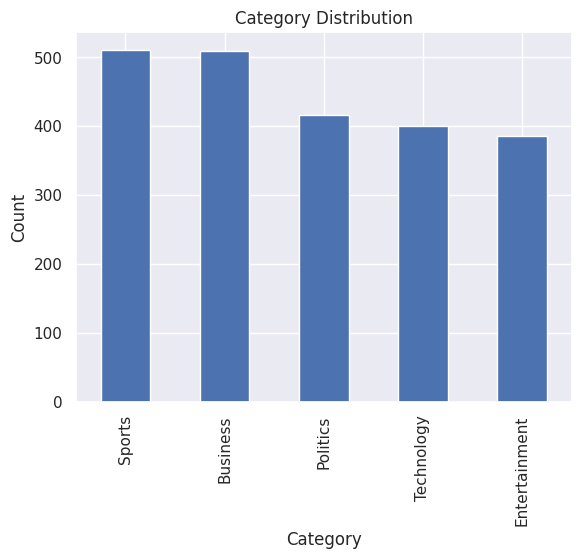

In [ ]:
articles.Category.value_counts().plot(kind='bar')
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [ ]:
from pprint import pprint

pprint(articles.iloc[921].to_dict(), compact=True)

{'Article': 'french boss to leave eads the french co-head of european defence '
            'and aerospace group eads philippe camus is to leave his post.  mr '
            'camus said in a statement that he has accepted the invitation to '
            'return full-time to the lagardere group  which owns 30% of eads.  '
            'i will give up my role as soon as the board of directors asks me '
            'to do so   he said. airbus head noel forgeard is now set to '
            'replace mr camus  bringing the company s power struggle to an '
            'end. fighting between mr camus and mr forgeard has hit the '
            'headlines in france and analysts feared that this fighting could '
            'destabilise the defence and aerospace group. french finance '
            'minister herve gaymard is on record as saying that he  deplored  '
            'the infighting at the company. the company should now be able put '
            'this dispute behind it  with the departure 

In [ ]:
articles.describe(include='all')

,Category,Article
count,2225,2225
unique,5,2126
top,Sports,kennedy questions trust of blair lib dem leade...
freq,511,2


In [ ]:
articles.duplicated().sum()

99

In [ ]:
df = articles.drop_duplicates()

In [ ]:
df.shape

(2126, 2)

## Text Preprocessing

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.output = None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.Series):
            X = X.to_frame()
        output = pd.DataFrame()
        # print(type(X))
        for col in X.columns:
            output[col] = X[col].apply(self.process_text)
        return output

    def process_text(self, text):
        # remove non words
        # print(type(text))
        text = re.sub(r'\W', ' ', text)

        # tokenize and remove stop words
        words = word_tokenize(text)
        filtered_words = [word for word in words if word not in self.stop_words]

        # perform lemmatization
        lemmatized_words = [self.lemmatizer.lemmatize(word) for word in filtered_words]

        return ' '.join(lemmatized_words)

    def get_feature_names_out(self):
        pass


In [ ]:
# write a columnTransformer for converting Category column to integer
# transform_cols = ColumnTransformer([('text_preprocess', TextProcessor(), ['Article'])], remainder='passthrough')

preprocess = Pipeline([
    ('text_prep', TextProcessor()),
])


In [ ]:
preprocess.fit_transform(df.head()).shape

(5, 2)

In [ ]:
X, y = df.Article, df.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, stratify=y, random_state=42)

target_encoder = OrdinalEncoder()
target_encoder.fit(y_train.values.reshape(-1, 1))
y_train = target_encoder.transform(y_train.values.reshape(-1, 1)).reshape(-1)
y_test = target_encoder.transform(y_test.values.reshape(-1, 1)).reshape(-1)

X_train = preprocess.fit_transform(X_train).squeeze()
X_test = preprocess.transform(X_test).squeeze()


In [ ]:
tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

tfidf_pipeline.fit(X_train.squeeze(), y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
y_pred = tfidf_pipeline.predict(X_test)
y_pred_proba = tfidf_pipeline.predict_proba(X_test)

print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred_proba, multi_class="ovo"):>8.3f}')


# Computing the precision, recall & f1 score -
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision    : {precision:>8.3f}")
print(f"Recall       : {recall:>8.3f}")
print(f"F1 Score     : {f1:>8.3f}")

ROC AUC Score:    0.999
Precision    :    0.967
Recall       :    0.965
F1 Score     :    0.965


In [ ]:
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       101
         1.0       1.00      0.92      0.96        74
         2.0       0.96      0.98      0.97        81
         3.0       0.97      1.00      0.99       101
         4.0       1.00      0.90      0.95        69

    accuracy                           0.96       426
   macro avg       0.97      0.96      0.96       426
weighted avg       0.97      0.96      0.96       426

Accuracy: 0.9647887323943662


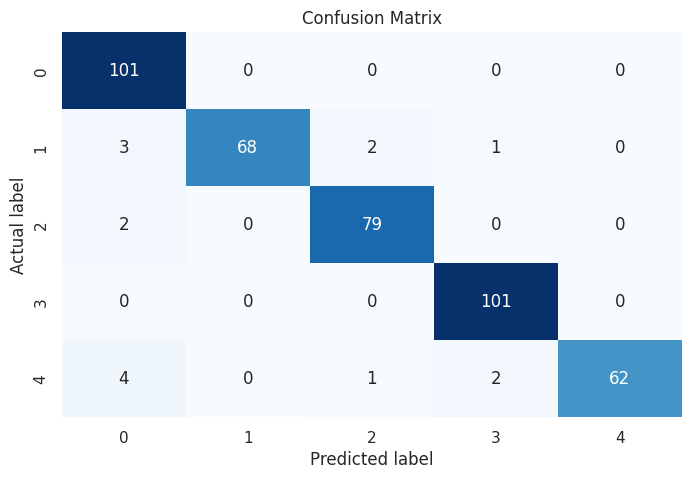

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()

In [ ]:
def train_and_evaluate(X_train, X_test, y_train, y_test, preprocess, classifiers):
    for name, classifier in classifiers.items():
        model = Pipeline([
            ('prep', preprocess),
            # ('scale', StandardScaler(with_mean=False)),
            ('name', classifier)
        ])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        print(f'{name:-^70}')
        # Computing the ROC AUC score
        print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred_proba, multi_class="ovo"):>8.3f}')

        # Computing the precision, recall & f1 score -
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"Precision    : {precision:>8.3f}")
        print(f"Recall       : {recall:>8.3f}")
        print(f"F1 Score     : {f1:>8.3f}")

        # print('Classification Report:')
        # print(classification_report(y_test, y_pred, zero_division=0))
    print('*'*80)
    print()


classifiers = {
    "lgb": LogisticRegression(),
    "knn": KNeighborsClassifier(n_neighbors=5),
    "dt": DecisionTreeClassifier(),
    "rf": RandomForestClassifier(),
    "xgb": XGBClassifier(),
}

In [ ]:
# train_and_evaluate(X_train, X_test, y_train, y_test, CountVectorizer(), classifiers)


In [ ]:
train_and_evaluate(X_train, X_test, y_train, y_test, TfidfVectorizer(), classifiers)


---------------------------------lgb----------------------------------
ROC AUC Score: 0.999

Precision    :    0.980
Recall       :    0.979
F1 Score     :    0.979
---------------------------------knn----------------------------------
ROC AUC Score: 0.990

Precision    :    0.951
Recall       :    0.951
F1 Score     :    0.951
----------------------------------dt----------------------------------
ROC AUC Score: 0.897

Precision    :    0.848
Recall       :    0.845
F1 Score     :    0.845
----------------------------------rf----------------------------------
ROC AUC Score: 0.998

Precision    :    0.963
Recall       :    0.960
F1 Score     :    0.960
---------------------------------xgb----------------------------------
ROC AUC Score: 0.997

Precision    :    0.943
Recall       :    0.941
F1 Score     :    0.942
********************************************************************************

